In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('u1.base', sep='\t', header=None, names=rnames)
ratings

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
5,1,7,4,875071561
6,1,8,1,875072484
7,1,9,5,878543541
8,1,11,2,875072262
9,1,13,5,875071805


In [3]:
M = 1682 #number of movies
N = 943 #number of users

R = np.zeros((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    r = ratings['rating'][k]
    R[i,j] = 1.0

print R

[[1. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


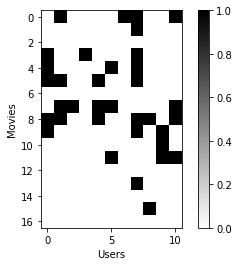

In [4]:
Data = R[3:20,5:16] #Sample from original data matrix

plt.imshow(Data, interpolation='nearest',vmax=1,vmin=0)
plt.colorbar()
plt.set_cmap('binary')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

In [5]:
x_train = np.zeros((M*N,M+N))
for i in range(M):
    for j in range(N):
        x_train[i*N+j,i] = 1.0
        x_train[i*N+j,j+M] = 1.0

In [6]:
x_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
y_train = R.reshape(M*N)

In [8]:
print y_train

[1. 1. 0. ... 0. 0. 0.]


In [9]:
x_train, y_train = map(torch.tensor, (np.float32(x_train), np.float32(y_train)))

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_m = nn.Linear(M,32)
        self.linear_u = nn.Linear(N,32)
        self.linear1 = nn.Linear(64,16)
        self.linear2 = nn.Linear(16,8)
        self.linear3 = nn.Linear(32+8,1)

    def forward(self, x):
        x_m = x[:,0:M]
        x_u = x[:,M:M+N]
        x_m = self.linear_m(x_m)
        x_u = self.linear_u(x_u)
        x_d = torch.mul(x_m,x_u)
        x = torch.cat((x_m,x_u),-1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.cat((x_d,x),-1)
        x = torch.sigmoid(self.linear3(x))
        return torch.squeeze(x)

In [20]:
net = Net()
print(net)

Net(
  (linear_m): Linear(in_features=1682, out_features=32, bias=True)
  (linear_u): Linear(in_features=943, out_features=32, bias=True)
  (linear1): Linear(in_features=64, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=40, out_features=1, bias=True)
)


In [21]:
out = net(x_train)
print(out)

tensor([0.4703, 0.4703, 0.4705,  ..., 0.4703, 0.4706, 0.4704],
       grad_fn=<SqueezeBackward0>)


In [22]:
#binary_cross_entropy_with_logits kullanırsak sonda yaptığımız sigmoid'e
#gerek kalmıyor. cross_entropy de aynı şekilde softmax istemiyor 
loss_func = F.binary_cross_entropy

In [23]:
loss_func(net(x_train), y_train)

tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward>)

In [24]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)

In [25]:
from torch import optim
def get_model():
    model = Net()
    return model, optim.SGD(model.parameters(), lr=0.05)

In [26]:
model, opt = get_model()

for epoch in range(5):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    print(loss)

print(loss_func(model(x_train), y_train))

tensor(0.1616, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0955, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0877, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2223, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1375, grad_fn=<BinaryCrossEntropyBackward>)


In [27]:
pred = model(x_train)

In [28]:
R_pred = pred.detach().numpy().reshape(M,N)

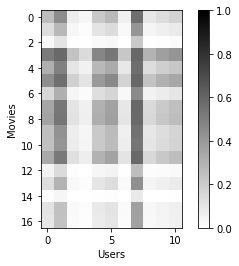

In [29]:
Data = R_pred[3:20,5:16] #Sample from original data matrix

plt.imshow(Data, interpolation='nearest',vmax=1,vmin=0)
plt.colorbar()
plt.set_cmap('binary')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()